In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import warnings
import time

warnings.filterwarnings("ignore")

from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
)

In [4]:
# loading data
X_train_balanced = np.load(
    "/home/samir-dahal/Diabetes_Classification/data/processed/X_train_balanced.npy"
)
y_train_balanced = np.load(
    "/home/samir-dahal/Diabetes_Classification/data/processed/y_train_balanced.npy"
)
X_test = pd.read_csv(
    "/home/samir-dahal/Diabetes_Classification/data/processed/X_test.csv"
)
y_test = pd.read_csv(
    "/home/samir-dahal/Diabetes_Classification/data/processed/y_test.csv"
)

## SVM with Hyperparameter Tuning

In [5]:
param_grid = {
    "C": [0.1, 1, 10, 100],  # Regularization
    "kernel": ["linear", "rbf", "poly"],  # Kernel type
    "gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1],  # Kernel coefficient
    "degree": [2, 3, 4],  # For polynomial kernel
    "class_weight": [None, "balanced"],  # Handle imbalance
}

In [ ]:
svm_base = SVC(
    random_state=42,
    probability=True,
    verbose=False,
)

In [7]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
# RandomizedSearchCV
svm_random = RandomizedSearchCV(
    estimator=svm_base,
    param_distributions=param_grid,
    n_iter=50,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True,
)

In [9]:
start_time = time.time()
svm_random.fit(X_train_balanced, y_train_balanced)
search_time = time.time() - start_time

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END C=0.1, class_weight=balanced, degree=3, gamma=auto, kernel=linear; total time=   0.2s
[CV] END C=0.1, class_weight=balanced, degree=3, gamma=auto, kernel=linear; total time=   0.2s
[CV] END C=100, class_weight=balanced, degree=4, gamma=0.01, kernel=rbf; total time=   0.2s
[CV] END C=1, class_weight=balanced, degree=3, gamma=scale, kernel=linear; total time=   0.2s
[CV] END C=100, class_weight=balanced, degree=4, gamma=0.01, kernel=rbf; total time=   0.2s
[CV] END C=100, class_weight=balanced, degree=4, gamma=0.01, kernel=rbf; total time=   0.2s
[CV] END C=1, class_weight=balanced, degree=3, gamma=scale, kernel=linear; total time=   0.2s
[CV] END C=100, class_weight=balanced, degree=4, gamma=0.01, kernel=rbf; total time=   0.2s
[CV] END C=1, class_weight=balanced, degree=3, gamma=scale, kernel=linear; total time=   0.2s
[CV] END C=0.1, class_weight=balanced, degree=3, gamma=auto, kernel=linear; total time=   0.3s
[CV

In [15]:
svm_best = svm_random.best_estimator_
print(svm_best)


SVC(C=10, class_weight='balanced', degree=2, gamma=1, probability=True,
    random_state=42)


## Model Evaluation on Test Set

In [ ]:
# Predictions
y_pred_svm = svm_best.predict(X_test)
y_pred_proba_svm = svm_best.predict_proba(X_test)

In [16]:
# Calculate metrics
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average=None, zero_division=0)
recall_svm = recall_score(y_test, y_pred_svm, average=None, zero_division=0)
f1_svm = f1_score(y_test, y_pred_svm, average=None, zero_division=0)

precision_macro_svm = precision_score(
    y_test, y_pred_svm, average="macro", zero_division=0
)
recall_macro_svm = recall_score(y_test, y_pred_svm, average="macro", zero_division=0)
f1_macro_svm = f1_score(y_test, y_pred_svm, average="macro", zero_division=0)

print(f"Overall accuracy: {accuracy_svm}")

Overall accuracy: 0.9326424870466321


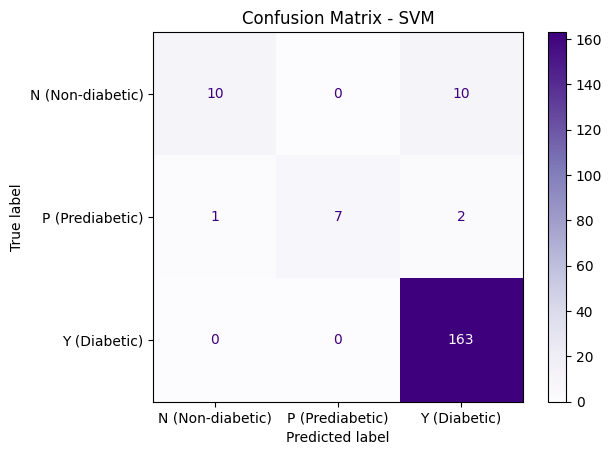

In [18]:
class_names = ["N (Non-diabetic)", "P (Prediabetic)", "Y (Diabetic)"]

cm_svm = confusion_matrix(y_test, y_pred_svm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=class_names)
disp.plot(cmap="Purples", values_format="d")
plt.title("Confusion Matrix - SVM")
plt.show()

Total training samples: 1941
Total support vectors: 794
Percentage: 40.91%

Support vectors per class:
  N (Non-diabetic): 172
  P (Prediabetic): 101
  Y (Diabetic): 521


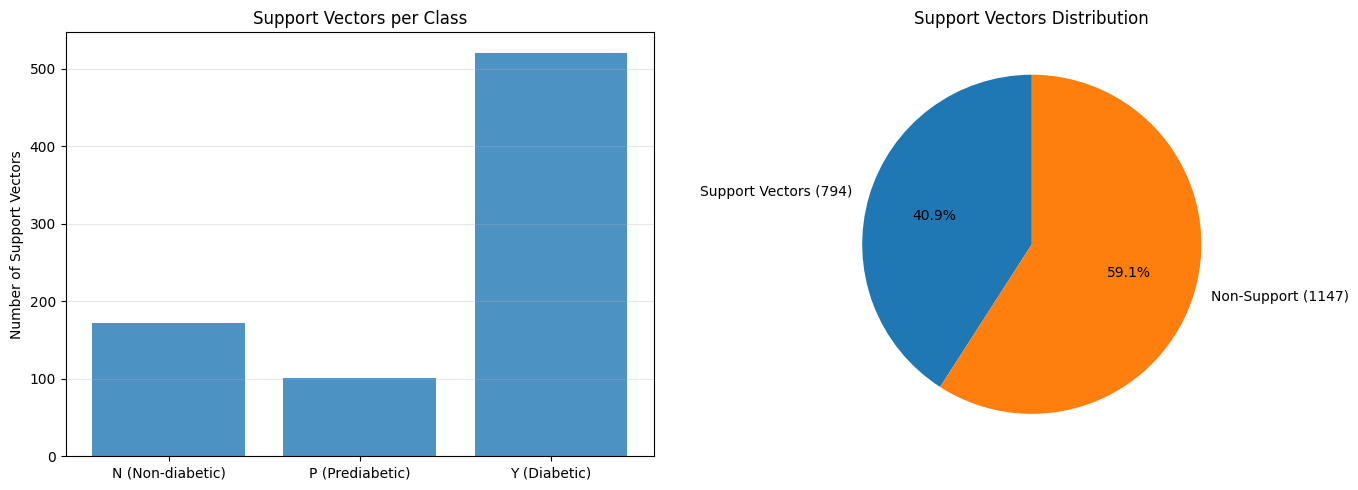

In [19]:
# Support vectors analysis
n_support = svm_best.n_support_
total_support_vectors = np.sum(n_support)
total_training_samples = len(X_train_balanced)

print(f"Total training samples: {total_training_samples}")
print(f"Total support vectors: {total_support_vectors}")
print(f"Percentage: {total_support_vectors / total_training_samples * 100:.2f}%")
print(f"\nSupport vectors per class:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}: {n_support[i]}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(class_names, n_support, alpha=0.8)
axes[0].set_ylabel("Number of Support Vectors")
axes[0].set_title("Support Vectors per Class")
axes[0].grid(axis="y", alpha=0.3)

sizes = [total_support_vectors, total_training_samples - total_support_vectors]
labels = [
    f"Support Vectors ({total_support_vectors})",
    f"Non-Support ({total_training_samples - total_support_vectors})",
]
axes[1].pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
axes[1].set_title("Support Vectors Distribution")

plt.tight_layout()
plt.show()

In [20]:
# Save model
with open(
    "/home/samir-dahal/Diabetes_Classification/models/classification/svm.pkl",
    "wb",
) as f:
    pickle.dump(svm_best, f)
# save metrix
metrics_df = pd.DataFrame(
    [
        {
            "Model": "SVM",
            "Accuracy": accuracy_svm,
            "Precision (macro)": precision_macro_svm,
            "Recall (macro)": recall_macro_svm,
            "F1-Score (macro)": f1_macro_svm,
            "F1 (N)": f1_svm[0],
            "F1 (P)": f1_svm[1],
            "F1 (Y)": f1_svm[2],
            "Training Time (s)": search_time,
            "CV F1 Mean": svm_random.best_score_,
            "CV F1 Std": svm_random.cv_results_["std_test_score"][svm_random.best_index_],
        }
    ]
)


existing_metrics = pd.read_csv(
    "/home/samir-dahal/Diabetes_Classification/results/classification_results/classification_metrics.csv"
)
updated_metrics = pd.concat([existing_metrics, metrics_df], ignore_index=True)
updated_metrics.to_csv(
    "/home/samir-dahal/Diabetes_Classification/results/classification_results/classification_metrics.csv",
    index=False,
)

print("Model and metrics saved successfully")

Model and metrics saved successfully
